In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss, ConfusionMatrixDisplay

plt.rcParams['figure.dpi'] = 500

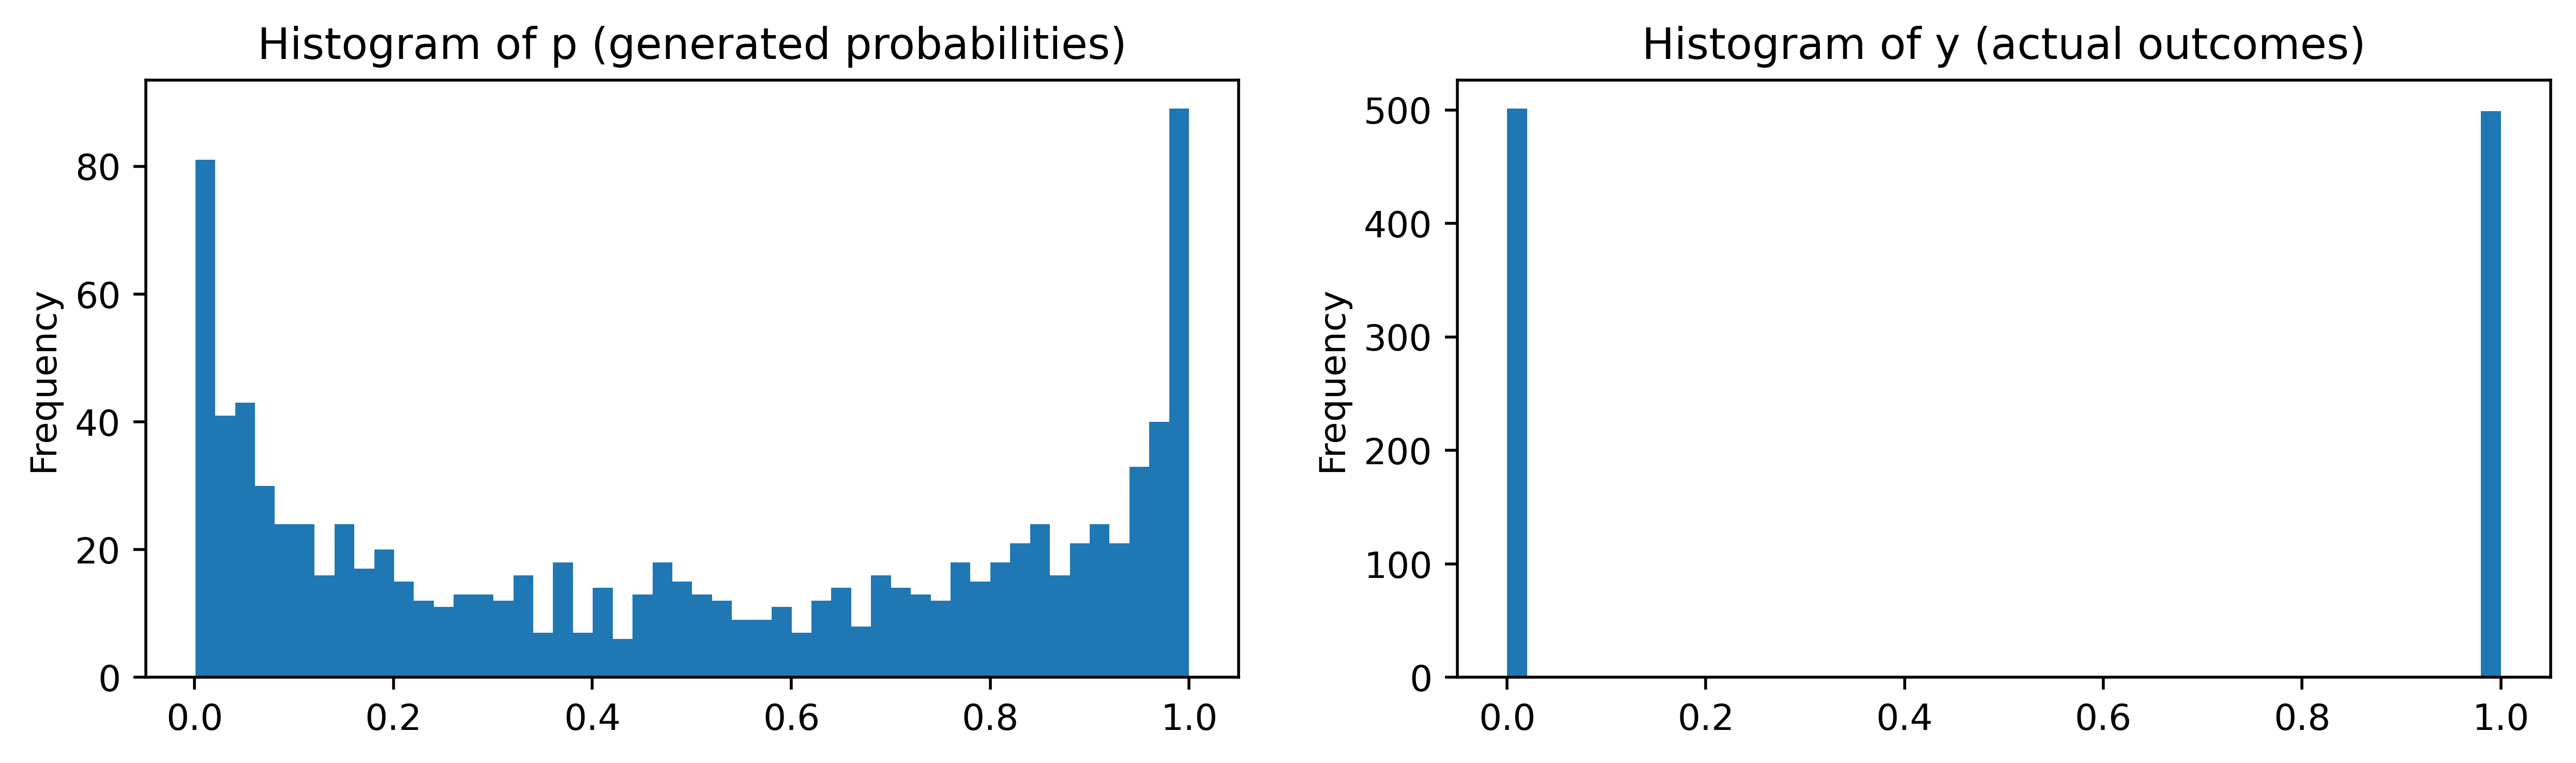

In [2]:
def logit(p):
    return np.log(p/(1-p))

def extremize2d(x, y, a=1):
    return (x*y)**a/((x*y)**a + ((1-x)*(1-y))**a)

def extremize(predictions_array, a=1):
    """
    predictions_array (n, p): n is the number of forecasts, p is the number of forecasters
    """
    # Logic of the code: transposing does nothing if it's a 1D array
    # Also, axis=0 exists for both 1D arrays and 2D
    Π = np.product(predictions_array.T, axis=0)
    return Π**a/(Π**a+np.product(1-predictions_array.T, axis=0)**a)

def generate_logit_samples(μ, cov, β0, β, N=10_000):
    # Simulation
    X = np.random.multivariate_normal(μ, cov, size=N)
    log_ps = β0 + X @ β
    ps = np.exp(log_ps)/(1+np.exp(log_ps))
    y = (np.random.uniform(size=N) <= ps).astype(int) # -> if p = 0.8, the uniform sample has 80% prob of being 1
    
    # Putting the results into a dataframe for convenience
    samples = pd.DataFrame(X)
    samples.columns = [f'x_{i}' for i in range(1, len(μ)+ 1)]
    samples['p'] = ps
    samples['y'] = y
    return samples


ρ12 = 0.5
ρ13 = 0.4
ρ23 = 0.3
cov = [[1, ρ12, ρ13], # Note that I can get away with using correlations as covariances only because *all* standard devs are 1
       [ρ12, 1, ρ23],
       [ρ13, ρ23, 1]]
μ = np.zeros(3)

β = np.array([1.2, 1.20, 1.2])

samples = generate_logit_samples(μ, cov, 0, β, N=1_000)

fig, axarray = plt.subplots(1, 2, figsize=(6*2, 3))
pd.Series(samples['p']).plot.hist(bins=50, ax=axarray[0], title='Histogram of p (generated probabilities)');
pd.Series(samples['y']).plot.hist(bins=50, ax=axarray[1], title='Histogram of y (actual outcomes)');

In [3]:
samples = sm.add_constant(samples)

info_known_to_forecaster1 = samples[['const', 'x_1']] # They obviously know the outcomes as well
info_known_to_forecaster2 = samples[['const', 'x_2']]
info_known_to_forecaster3 = samples[['const', 'x_3']]

model_forecaster1 = sm.Logit(samples['y'], info_known_to_forecaster1)
model_forecaster2 = sm.Logit(samples['y'], info_known_to_forecaster2)
model_forecaster3 = sm.Logit(samples['y'], info_known_to_forecaster3)

results_forecaster1 = model_forecaster1.fit()
results_forecaster2 = model_forecaster2.fit()
results_forecaster3 = model_forecaster3.fit()

Optimization terminated successfully.
         Current function value: 0.517119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555896
         Iterations 6


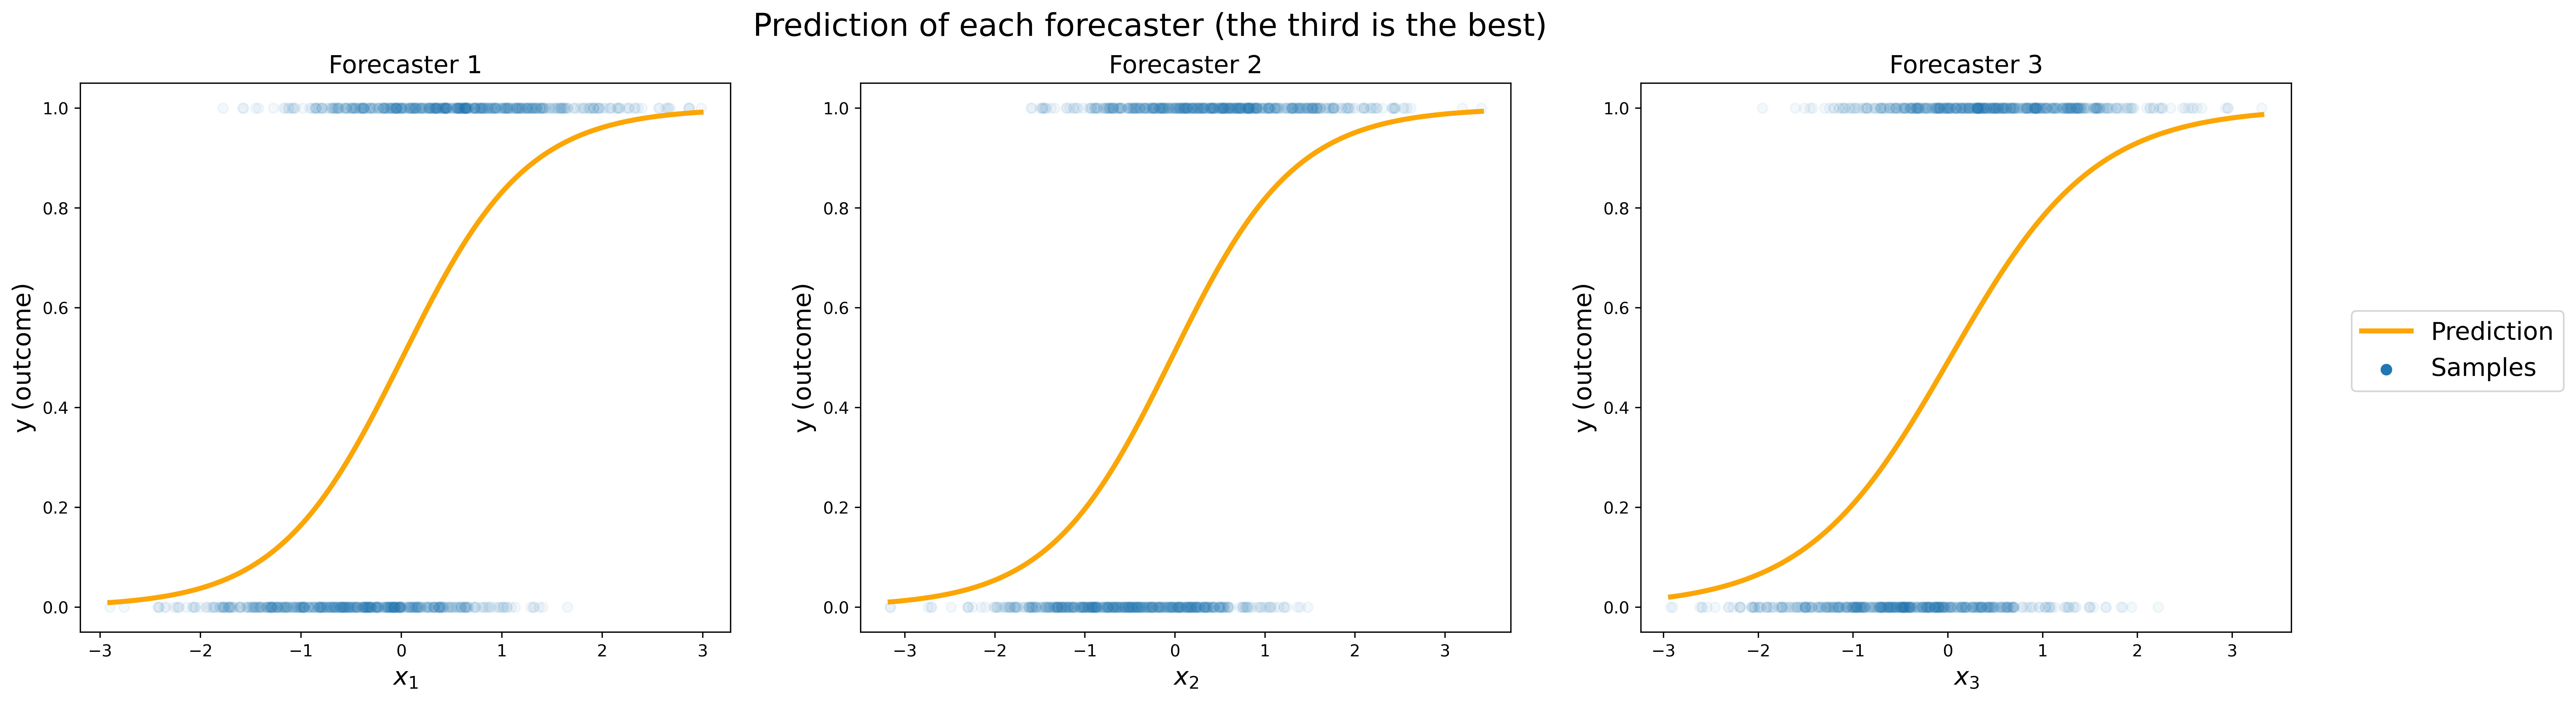

In [4]:
fig, axarray = plt.subplots(1, 3, figsize=(8*3,6))

x1 = sm.add_constant(np.linspace(samples['x_1'].min(), samples['x_1'].max(), 1000).reshape(-1, 1))
x2 = sm.add_constant(np.linspace(samples['x_2'].min(), samples['x_2'].max(), 1000).reshape(-1, 1))
x3 = sm.add_constant(np.linspace(samples['x_3'].min(), samples['x_3'].max(), 1000).reshape(-1, 1))

axarray[0].plot(x1[:, 1], results_forecaster1.predict(x1), color='orange', lw=3, label='Prediction')
axarray[1].plot(x2[:, 1], results_forecaster2.predict(x2), color='orange', lw=3)
axarray[2].plot(x3[:, 1], results_forecaster3.predict(x3), color='orange', lw=3)

for i, ax in enumerate(axarray):
    ax.scatter(samples[f'x_{i+1}'], samples['y'], alpha=0.05, label='Samples' if i == 0 else None)
    ax.set_xlabel(f'$x_{i+1}$', fontsize=15)
    ax.set_ylabel('y (outcome)', fontsize=15)
    ax.set_title(f'Forecaster {i+1}', fontsize=15)

legend = fig.legend(fontsize=15, loc='center right')
for lh in legend.legendHandles: 
    lh.set_alpha(1)
fig.suptitle("Prediction of each forecaster (the third is the best)", fontsize=19);

In [5]:
p1 = results_forecaster1.predict(samples[['const', 'x_1']])
p2 = results_forecaster2.predict(samples[['const', 'x_2']])
p3 = results_forecaster3.predict(samples[['const', 'x_3']])

expo = 1.5
p = extremize(np.array([p1, p2, p3]).T, expo)

pd.DataFrame({
    'Brier Scores':[brier_score_loss(samples['y'], preds) for preds in [p1, p2, p3, p, np.mean([p1, p2, p3], axis=0)]]}, 
    index=[f'Forecaster {i}' for i in range(1, 4)]+["Extremized", "Mean forecast"]).round(4)

,Brier Scores
Forecaster 1,0.1742
Forecaster 2,0.1823
Forecaster 3,0.1886
Extremized,0.1373
Mean forecast,0.1535


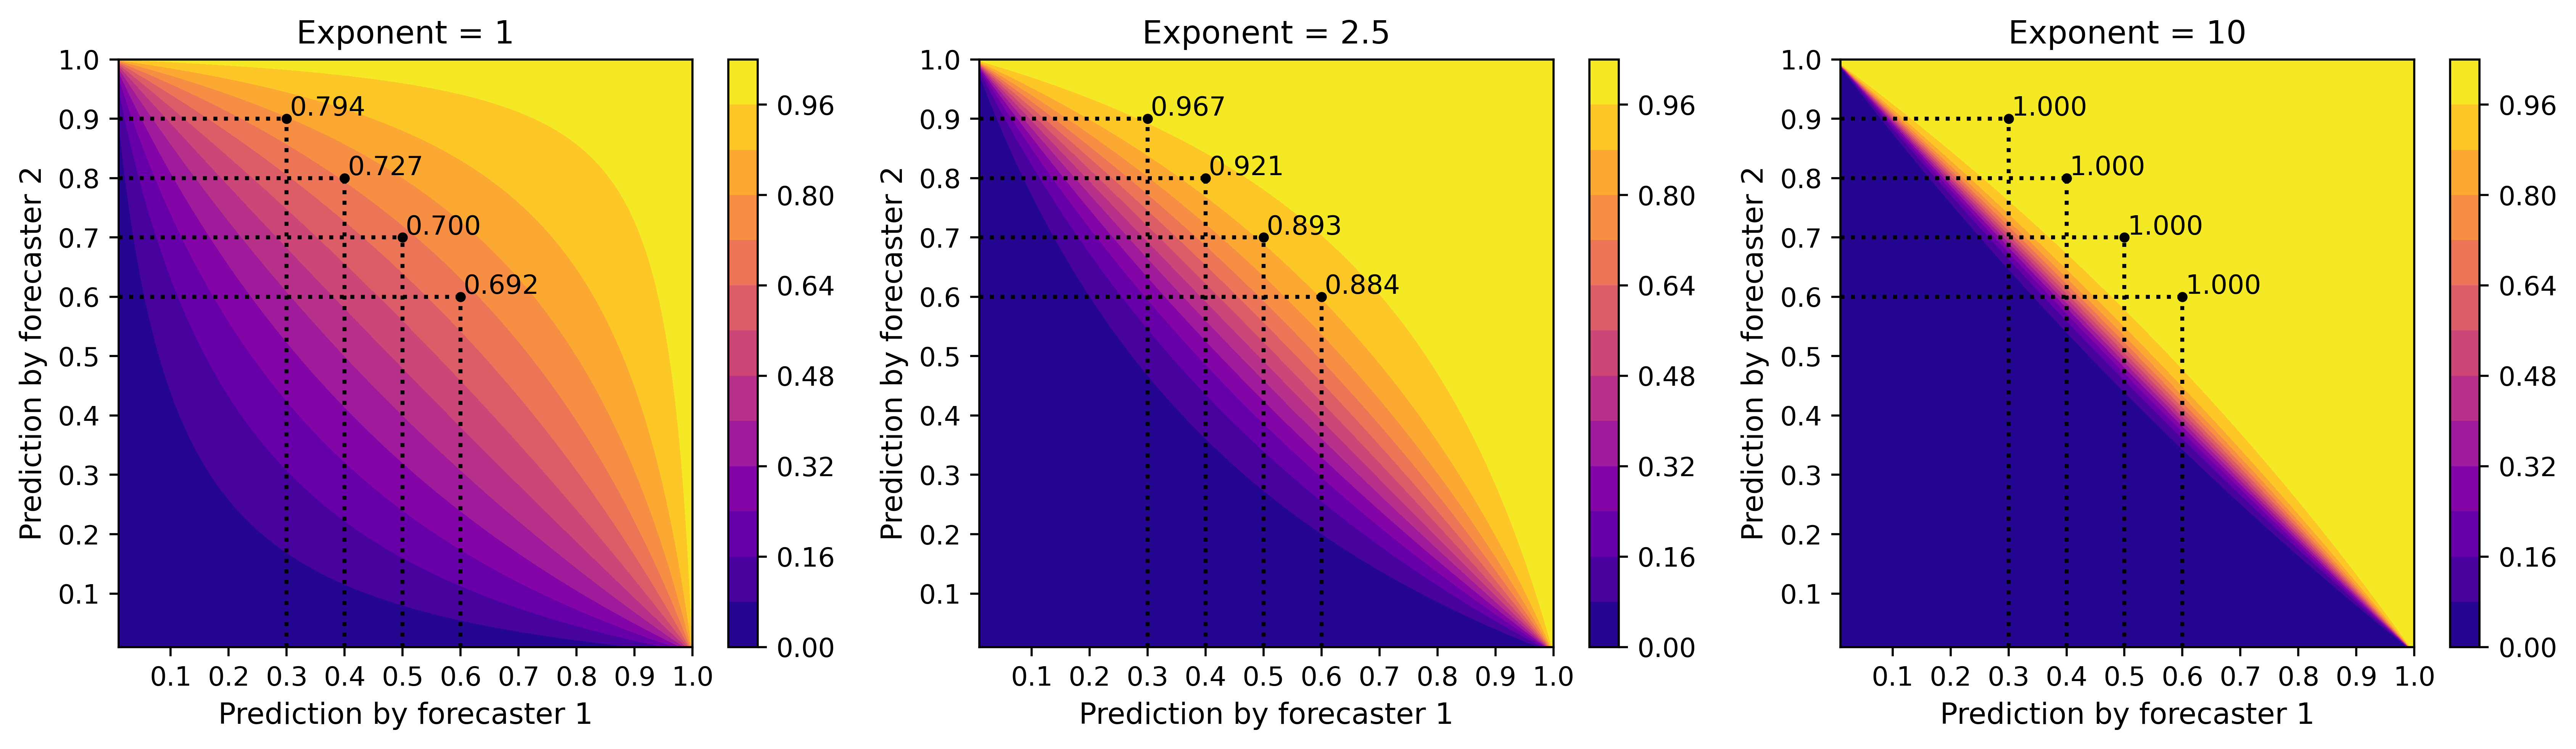

In [6]:
x = np.linspace(0.01, 1, 1000)
y = np.linspace(0.01, 1, 1000)

X, Y = np.meshgrid(x, y)

fig, axarr = plt.subplots(1, 3, figsize=(5.5*3, 4))

for ax, exponent in zip(axarr, [1, 2.5, 10]):
    Z = extremize2d(X, Y, exponent)
    cs = ax.contourf(X, Y, Z,  15, cmap='plasma')
    fig.colorbar(cs, ax=ax);
    for point in [(0.6, 0.6), (0.5, 0.7), (0.4, 0.8), (0.3, 0.9)]:
        ax.scatter(point[0],point[1], color='black', s=8);
        ax.annotate(f"{extremize2d(point[0],point[1],exponent):.3f}", [point[0]+0.005,point[1]+0.005])
        ax.axvline(point[0], ymax=point[1], ls=':', color='black')
        ax.axhline(point[1], xmax=point[0], ls=':', color='black')
    ax.set_title(f"Exponent = {exponent}")
    ax.set_xlabel('Prediction by forecaster 1', fontsize=11)
    ax.set_ylabel('Prediction by forecaster 2', fontsize=11);
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.yaxis.set_major_locator(plt.MaxNLocator(11))

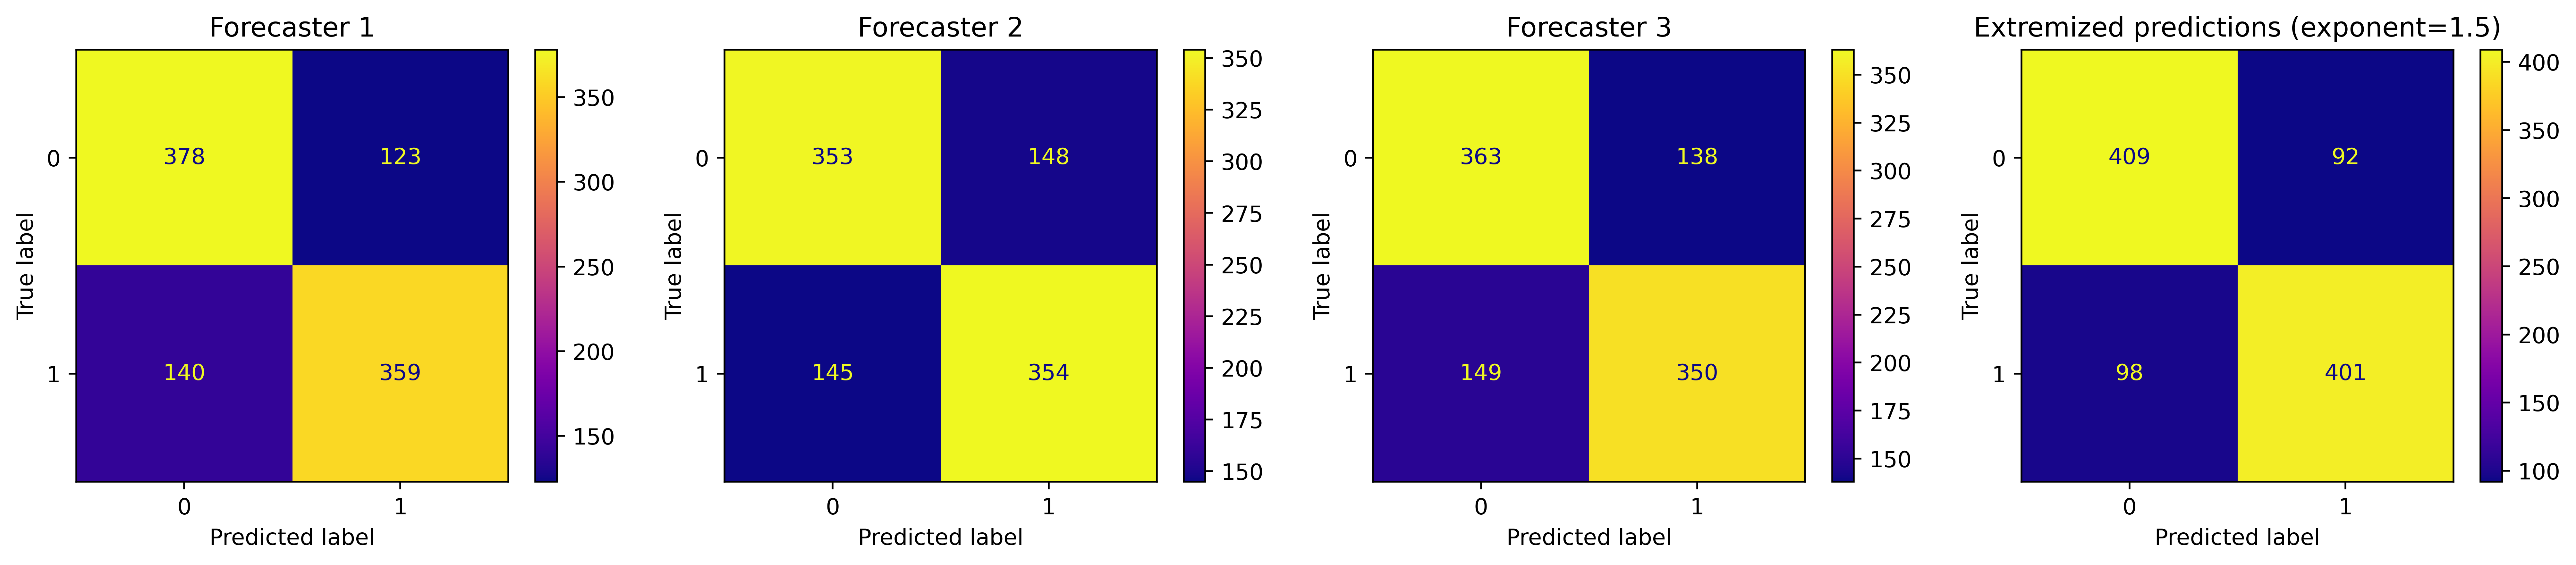

In [7]:
fig, axarray = plt.subplots(1, 4, figsize=(5*4, 3.5))
for ax, preds, title in zip(axarray, [p1, p2, p3, p], [f'Forecaster {i}' for i in range(1, 4)]+[f"Extremized predictions (exponent={expo})"]):
    ax.set_title(title)
    ConfusionMatrixDisplay.from_predictions(samples['y'], np.round(preds), cmap='plasma', ax=ax);